In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

import math
from scipy import optimize
import scipy.stats as stats
from scipy.stats import norm

# 1 Data Preprocessing

In [2]:
df = pd.read_excel('./closing_price.xlsx')
time = df['Bloomberg Ticker']
data = df['AAPL UW Equity']
# time,data

In [3]:
apple_price = data.values
# apple_price

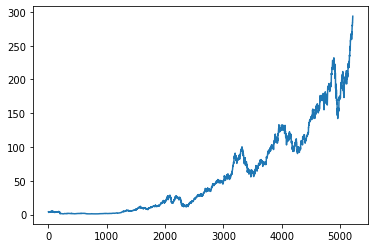

In [5]:
plt.plot(apple_price[1:len(apple_price)])
plt.show()

In [6]:
length=len(apple_price)
# length

In [7]:
x = [(apple_price[i]-apple_price[i-1])/apple_price[i-1] for i in range(1, apple_price.shape[0])]
# x

In [8]:
learning_set_x = x[:len(x)*3//4]
testing_set_x  = x[len(x)*3//4:]
len_learning   = len(learning_set_x)
len_testing    = len(testing_set_x)
len(learning_set_x),len(testing_set_x)

(3912, 1305)

In [9]:
epsilon = np.mean(learning_set_x)
# epsilon

In [10]:
d = ['D' if i < -epsilon else 'U' if i > epsilon else 'H' for i in x]
# d

In [13]:
learning_set_d = d[:len(d)*3//4]
testing_set_d  = d[len(d)*3//4:]
len(learning_set_d), len(testing_set_d)

(3912, 1305)

In [14]:
learning_set = apple_price[1:len_learning+1]
testing_set  = apple_price[len_learning+1:]
len(learning_set),len(testing_set)

(3912, 1305)

# 2 Cumulative Distribution Function

In [15]:
Ux = sorted([learning_set_x[i] for i in range(len(learning_set_x)-1) if d[i+1] == 'U'])
Dx = sorted([learning_set_x[i] for i in range(len(learning_set_x)-1) if d[i+1] == 'D'])

In [16]:
count, low, binsize, _ = stats.cumfreq(Ux, numbins=200)

cdf_U_x = [low]
for i in range(1,200):
    cdf_U_x.append(cdf_U_x[i-1]+binsize)
cdf_U = [count[i]/len(Ux) for i in range(200)]

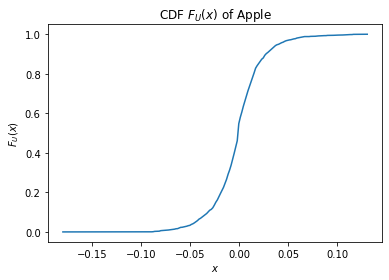

In [17]:
plt.plot(cdf_U_x, cdf_U)
plt.title('CDF $F_U(x)$ of Apple')
plt.ylabel('$F_U(x)$')
plt.xlabel('$x$')
plt.savefig("2-1")
plt.show()

In [18]:
count, low, binsize, _ = stats.cumfreq(Dx, numbins=200)
cdf_D_x = [low]
for i in range(1,200):
    cdf_D_x.append(cdf_D_x[i-1]+binsize)
cdf_D=[count[i]/len(Dx) for i in range(200)]

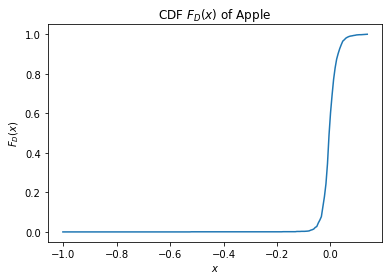

In [19]:
plt.plot(cdf_D_x,cdf_D)
plt.title('CDF $F_D(x)$ of Apple')
plt.ylabel('$F_D(x)$')
plt.xlabel('$x$')
plt.savefig("2-2")
plt.show()

# 3.Probability Density Function

In [20]:
def FD_distribution(x, b, x0):
    return 1/(1+np.exp(-b*(x-x0)))

In [21]:
b_U, x0_U = optimize.curve_fit(FD_distribution, cdf_U_x, cdf_U)[0]
b_D, x0_D = optimize.curve_fit(FD_distribution, cdf_D_x, cdf_D)[0]
# b_U, x0_U, b_D, x0_D

In [22]:
FU_FDFit = [FD_distribution(x, b_U, x0_U) for x in cdf_U_x]
FD_FDFit = [FD_distribution(x, b_D, x0_D) for x in cdf_D_x]

In [23]:
def fD_distribution(x, b, x0):
    return (b*np.exp(-b*(x-x0)))/(1+np.exp(-b*(x-x0)))**2

In [24]:
fU_FDFit = [fD_distribution(x, b_U, x0_U)/len(cdf_U_x) for x in cdf_U_x]
fD_FDFit = [fD_distribution(x, b_D, x0_D)/len(cdf_D_x) for x in cdf_D_x]

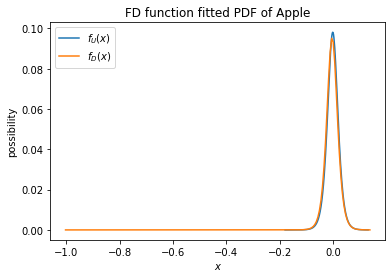

In [25]:
plt.plot(cdf_U_x, fU_FDFit, label="$f_U(x)$")
plt.plot(cdf_D_x, fD_FDFit, label="$f_D(x)$")
plt.title('FD function fitted PDF of Apple')
plt.ylabel('possibility')
plt.xlabel('$x$')
plt.legend()
plt.savefig("3-1")
plt.show()

In [26]:
def Gaussian_distribution(x, mu, sigma):
    return np.exp(-(x-mu)**2/(2*sigma**2))/np.sqrt(2*np.pi*sigma**2)

In [27]:
mean_U = np.mean(Ux)
std_U  = np.sqrt(sum((Ux-mean_U)**2)/len(Ux))

In [28]:
mean_D = np.mean(Dx)
std_D  = np.sqrt(sum((Dx-mean_D)**2)/len(Dx))

In [29]:
# mean_U, std_U, mean_D, std_D

In [30]:
gU_GaussianFit = [Gaussian_distribution(x, mean_U, std_U) for x in cdf_U_x]
gD_GaussianFit = [Gaussian_distribution(x, mean_D, std_D) for x in cdf_D_x]
# 这里我直接除了g的长度，不清楚你的纵坐标是怎么算的 (MQ)
# 直接代入公式，不用除别的（ZY）

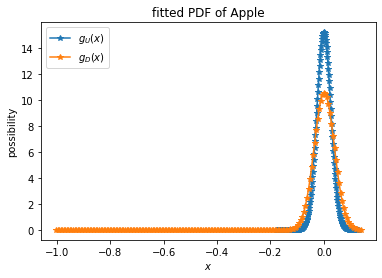

In [31]:
plt.plot(cdf_U_x, gU_GaussianFit,'-*', label="$g_U(x)$")
plt.plot(cdf_D_x, gD_GaussianFit,'-*', label="$g_D(x)$")
plt.title('fitted PDF of Apple')
plt.ylabel('possibility')
plt.xlabel('$x$')
plt.legend()
plt.savefig("3-2")
plt.show()

# 4 Bayes Detector
$$
H_0=U,H_1=D
$$
区间内U，区间外D

In [32]:
PU = len(Ux)/len(learning_set_x)
PD = len(Dx)/len(learning_set_x)

In [33]:
cUU, cUD, cDU, cDD = 0, 1, 1, 0
mu = ((cDU-cUU)*PU)/((cUD-cDD)*PD)

In [34]:
def find_cut_point_FD(args):
    x = args[0]
    return [
        ((b_D*np.exp(-b_D*(x-x0_D)))/(1+np.exp(-b_D*(x-x0_D)))**2)/((b_U*np.exp(-b_U*(x-x0_U)))/(1+np.exp(-b_U*(x-x0_U)))**2) - mu
    ]

In [35]:
cut_point_FD = [optimize.fsolve(find_cut_point_FD, [0.1])[0], optimize.fsolve(find_cut_point_FD, [-0.1])[0]]

In [36]:
cut_point_FD

[0.13659818604423596, -0.017125770813066352]

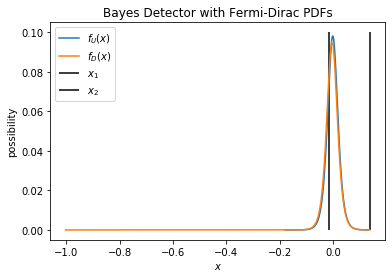

In [37]:
plt.plot(cdf_U_x, fU_FDFit, label="$f_U(x)$")
plt.plot(cdf_D_x, fD_FDFit, label="$f_D(x)$")
plt.vlines(cut_point_FD[0], 0, 0.1, label='$x_1$')
plt.vlines(cut_point_FD[1], 0, 0.1, label='$x_2$')
plt.title('Bayes Detector with Fermi-Dirac PDFs')
plt.ylabel('possibility')
plt.xlabel('$x$')
plt.legend()
plt.savefig("4-1")
plt.show()

In [38]:
def find_cut_point_Gaussian(args):
    x = args[0]
    return [
        (np.exp(-(x-mean_D)**2/(2*std_D**2))/np.sqrt(2*np.pi*std_D**2))/(np.exp(-(x-mean_U)**2/(2*std_U**2))/np.sqrt(2*np.pi*std_U**2)) - mu
    ]

In [39]:
cut_point_Gaussian = [optimize.fsolve(find_cut_point_Gaussian, [0.1])[0], optimize.fsolve(find_cut_point_Gaussian, [-0.1])[0]]

In [40]:
cut_point_Gaussian

[0.033171990447945145, -0.036076322357826304]

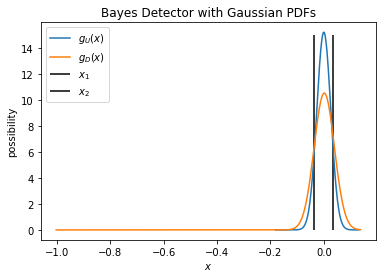

In [41]:
plt.plot(cdf_U_x, gU_GaussianFit, label="$g_U(x)$")
plt.plot(cdf_D_x, gD_GaussianFit, label="$g_D(x)$")
plt.vlines(cut_point_Gaussian[1], 0, 15, label='$x_1$')
plt.vlines(cut_point_Gaussian[0], 0, 15, label='$x_2$')
plt.title('Bayes Detector with Gaussian PDFs')
plt.ylabel('possibility')
plt.xlabel('$x$')
plt.legend()
plt.savefig("4-2")
plt.show()

# 5 Association Rules

#### 1-Day
$$
R^1_U:d(t)\rightarrow d(t+1)=U \\\
R^1_D:d(t)\rightarrow d(t+1)=D
$$

In [42]:
def alphabets(i):
    if i=='U':
        return 0
    if i=='D':
        return 1
    if i=='H':
        return 2

In [44]:
rule1 = np.zeros((3,3))
for i in range(len(learning_set_d)-1):
    rule1[alphabets(learning_set_d[i])][alphabets(learning_set_d[i+1])]+=1
print(rule1)

[[860. 854. 156.]
 [841. 741. 139.]
 [169. 126.  25.]]


Find the best 1-day rules of $R^1_D$ and $R^1_U$

In [45]:
# Support
for i in range(len(rule1)):
    support = np.sum(rule1[i])/np.sum(rule1)
    print('Support on {}: {}'.format(i, support))

Support on 0: 0.4781385834824853
Support on 1: 0.4400409102531322
Support on 2: 0.08182050626438252


In [46]:
# Confidence
for i in range(len(rule1)):
    for j in range(len(rule1[0])):
        confidence = rule1[i][j]/np.sum(rule1[i])
        print('Confidence on ({},{}): {}'.format(i, j, confidence))

Confidence on (0,0): 0.45989304812834225
Confidence on (0,1): 0.4566844919786096
Confidence on (0,2): 0.08342245989304813
Confidence on (1,0): 0.4886693782684486
Confidence on (1,1): 0.4305636257989541
Confidence on (1,2): 0.08076699593259733
Confidence on (2,0): 0.528125
Confidence on (2,1): 0.39375
Confidence on (2,2): 0.078125


From the support, we choose U or D. From the confidence, we choose DU for $R^1_U$ and UD for $R^1_D$.

In [47]:
print("rule \t support \t confidence")
print("DU \t "+str(np.sum(rule1[1])/np.sum(rule1)) +"\t "+str(rule1[1][0]/np.sum(rule1[1])))
print("UD \t "+str(np.sum(rule1[0])/np.sum(rule1)) +"\t "+str(rule1[0][1]/np.sum(rule1[0])))

rule 	 support 	 confidence
DU 	 0.4400409102531322	 0.4886693782684486
UD 	 0.4781385834824853	 0.4566844919786096


In [97]:
conf_U1 = [rule1[0][0]/np.sum(rule1[0]), rule1[1][0]/np.sum(rule1[1]), rule1[2][0]/np.sum(rule1[2])]
conf_D1 = [rule1[0][1]/np.sum(rule1[0]), rule1[1][1]/np.sum(rule1[1]), rule1[2][1]/np.sum(rule1[2])]
conf_H1 = [rule1[0][2]/np.sum(rule1[0]), rule1[1][2]/np.sum(rule1[1]), rule1[2][2]/np.sum(rule1[2])]

#### 5-Day
$$
R^5_U:\{d(t-4),d(t-3),d(t-2),d(t-1),d(t)\}\rightarrow d(t+1)=U \\\
R^5_D:\{d(t-4),d(t-3),d(t-2),d(t-1),d(t)\}\rightarrow d(t+1)=D
$$

In [49]:
rule2   = np.zeros((3,3,3,3,3))
count_U = np.zeros((3,3,3,3,3))
count_D = np.zeros((3,3,3,3,3))

for i in range(5, len_learning):
    rule2[alphabets(learning_set_d[i-5])][alphabets(learning_set_d[i-4])][alphabets(learning_set_d[i-3])][alphabets(learning_set_d[i-2])][alphabets(learning_set_d[i-1])]+=1
    if learning_set_d[i]=='U':
        count_U[alphabets(learning_set_d[i-5])][alphabets(learning_set_d[i-4])][alphabets(learning_set_d[i-3])][alphabets(learning_set_d[i-2])][alphabets(learning_set_d[i-1])]+=1
    elif learning_set_d[i]=='D':
        count_D[alphabets(learning_set_d[i-5])][alphabets(learning_set_d[i-4])][alphabets(learning_set_d[i-3])][alphabets(learning_set_d[i-2])][alphabets(learning_set_d[i-1])]+=1

In [50]:
U_best_conf=-float('inf')
D_best_conf=-float('inf')
U_best_rule=[0,0,0,0,0]
D_best_rule=[0,0,0,0,0]
conf_U = np.zeros((3,3,3,3,3))
conf_D = np.zeros((3,3,3,3,3))
conf_H = np.zeros((3,3,3,3,3))
for i in range(3):
    for j in range(3):
        for k in range(3):
            for l in range(3):
                for m in range(3):
                    if rule2[i][j][k][l][m]!=0:
                        conf_U[i][j][k][l][m] = count_U[i][j][k][l][m]/rule2[i][j][k][l][m]
                        conf_D[i][j][k][l][m] = count_D[i][j][k][l][m]/rule2[i][j][k][l][m]
                        conf_H[i][j][k][l][m] = 1-conf_U[i][j][k][l][m]-conf_D[i][j][k][l][m]
                        if conf_U[i][j][k][l][m]>=U_best_conf and rule2[i][j][k][l][m]>rule2[U_best_rule[0]][U_best_rule[1]][U_best_rule[2]][U_best_rule[3]][U_best_rule[4]]:
                            # 因为有一些support很小但confidence很大的，我把它们当成干扰因素，就用了两个限制条件去筛选best rule
                            U_best_rule = [i,j,k,l,m]
                            U_best_conf = conf_U[i][j][k][l][m]
                        if conf_D[i][j][k][l][m]>=D_best_conf and rule2[i][j][k][l][m]>rule2[D_best_rule[0]][D_best_rule[1]][D_best_rule[2]][D_best_rule[3]][D_best_rule[4]]:
                            D_best_rule = [i,j,k,l,m]
                            D_best_conf = conf_D[i][j][k][l][m]

In [51]:
U_best_rule, U_best_conf, D_best_rule, D_best_conf

([0, 1, 1, 0, 1], 0.5, [1, 1, 0, 1, 0], 0.5)

In [62]:
# rule2, count_D, count_U

In [52]:
print("rule \t support \t confidence")
print("UDDUD \t "+str((rule2[U_best_rule[0]][U_best_rule[1]][U_best_rule[2]][U_best_rule[3]][U_best_rule[4]])/np.sum(rule2)) +"\t "+str(U_best_conf))
print("DDUDU \t "+str((rule2[D_best_rule[0]][D_best_rule[1]][D_best_rule[2]][D_best_rule[3]][D_best_rule[4]])/np.sum(rule1)) +"\t "+str(D_best_conf))

rule 	 support 	 confidence
UDDUD 	 0.02354747888405426	 0.5
DDUDU 	 0.026080286371771927	 0.5


# 6 Portfolio Management

In [176]:
M_FD=[0]*len_testing
N_FD=[0]*len_testing
M_FD[0]=100000
V_f=[]
gamma0=0.5#中等保守的投资者

for i in range(len_testing):
    conf_list = [conf_U1[alphabets(testing_set_d[i])], conf_D1[alphabets(testing_set_d[i])], conf_H1[alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    bayes_pred = -1
    if cut_point_FD[0]>=testing_set_x[i]>=cut_point_FD[1]:
        bayes_pred = 0
    else:
        bayes_pred = 1

    if max_index == bayes_pred == 0:
        # 表示接受第二天是U
        temp = gamma0*M_FD[i]
        M_FD[i]=M_FD[i]-temp
        N_FD[i]=N_FD[i]+temp/testing_set[i]
    elif max_index == bayes_pred == 1: 
        # 表示接受第二天是D
        temp = gamma0*N_FD[i]
        M_FD[i]=M_FD[i]+temp*testing_set[i]
        N_FD[i]=N_FD[i]-temp

    if i != len_testing-1:
        M_FD[i+1] = M_FD[i]
        N_FD[i+1] = N_FD[i]
        
    V_f.append(M_FD[i]+N_FD[i]*testing_set[i])

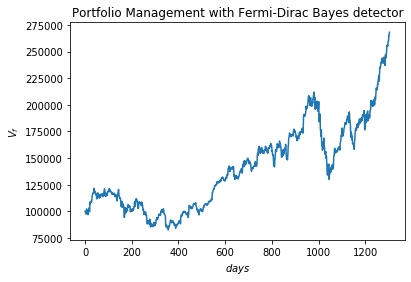

In [177]:
plt.plot(V_f)
plt.title('Portfolio Management with Fermi-Dirac Bayes detector')
plt.ylabel('$V_f$')
plt.xlabel('$days$')
plt.savefig("6-1")
plt.show()

In [183]:
V_f[-1]

268238.4474568656

In [179]:
M_g=[0]*len_testing
N_g=[0]*len_testing
M_g[0]=M_g[1]=100000
V_g=[100000]
gamma0=0.5#中等保守的投资者

for i in range(1, len_testing):
    conf_list = [conf_U1[alphabets(testing_set_d[i])], conf_D1[alphabets(testing_set_d[i])], conf_H1[alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    g_pred = -1
    if cut_point_Gaussian[0]>=testing_set_x[i]>=cut_point_Gaussian[1]:
        g_pred = 0
    else:
        g_pred = 1

    if max_index == g_pred == 0:
        # 表示接受第二天是U
        temp = gamma0*M_g[i]
        M_g[i]=M_g[i]-temp
        N_g[i]=N_g[i]+temp/testing_set[i]
    elif max_index == g_pred == 1: 
        # 表示接受第二天是D
        temp = gamma0*N_g[i]
        M_g[i]=M_g[i]+temp*testing_set[i]
        N_g[i]=N_g[i]-temp
    if i != len_testing-1:
        M_g[i+1] = M_g[i]
        N_g[i+1] = N_g[i]
        
    V_g.append(M_g[i]+N_g[i]*testing_set[i])

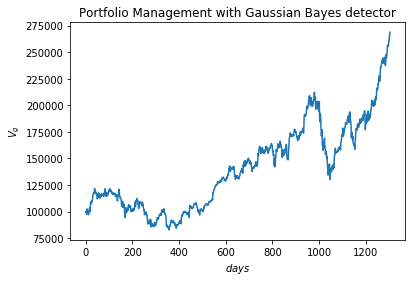

In [180]:
plt.plot(V_g)
plt.title('Portfolio Management with Gaussian Bayes detector')
plt.ylabel('$V_g$')
plt.xlabel('$days$')
plt.savefig("6-2")
plt.show()

In [182]:
V_g[-1]

268796.74864785466

The gaosi Bayes detector performs better.

Extra

In [184]:
M_5=[0]*len_testing
N_5=[0]*len_testing
M_5[0]=M_5[1]=M_5[2]=M_5[3]=M_5[4]=100000
V_5=M_5[:4]
gamma0=0.5#中等保守的投资者

for i in range(4,len_testing):
    conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    bayes_pred = -1
    if cut_point_FD[0]>=testing_set_x[i]>=cut_point_FD[1]:
        bayes_pred = 0
    else:
        bayes_pred = 1
    
    if max_index == bayes_pred == 0:
        # 表示接受第二天是U
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]-temp
        N_5[i]=N_5[i]+temp/testing_set[i]
    elif max_index == bayes_pred == 1:
        # 表示接受第二天是D
        temp=gamma0*N_5[i]
        M_5[i]=M_5[i]+temp*testing_set[i]
        N_5[i]=N_5[i]-temp
    if i != len_testing-1:
        M_5[i+1] = M_5[i]
        N_5[i+1] = N_5[i]


    V_5.append(M_5[i]+N_5[i]*testing_set[i])

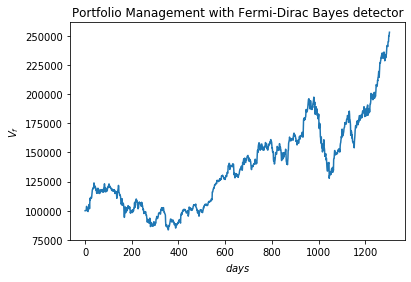

In [185]:
plt.plot(V_5)
plt.title('Portfolio Management with Fermi-Dirac Bayes detector')
plt.ylabel('$V_f$')
plt.xlabel('$days$')
plt.savefig("6-3")
plt.show()

In [186]:
V_5[-1]

253213.69880676776

In [187]:
M_5=[0]*len_testing
N_5=[0]*len_testing
M_5[0]=M_5[1]=M_5[2]=M_5[3]=M_5[4]=100000
V_5=M_5[:4]
gamma0=0.5#中等保守的投资者

for i in range(4,len_testing):
    conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    g_pred = -1
    if cut_point_Gaussian[0]>=testing_set_x[i]>=cut_point_Gaussian[1]:
        g_pred = 0
    else:
        g_pred = 1
    
    
    if max_index == g_pred == 0:
        # 表示接受第二天是U
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]-temp
        N_5[i]=N_5[i]+temp/testing_set[i]
    elif max_index == g_pred == 1:
        # 表示接受第二天是D
        temp = gamma0*N_5[i]
        M_5[i]=M_5[i]+temp*testing_set[i]
        N_5[i]=N_5[i]-temp

    if i != len_testing-1:
        M_5[i+1] = M_5[i]
        N_5[i+1] = N_5[i]

    V_5.append(M_5[i]+N_5[i]*testing_set[i])

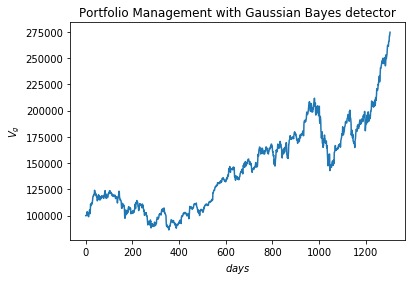

In [188]:
plt.plot(V_5)
plt.title('Portfolio Management with Gaussian Bayes detector')
plt.ylabel('$V_g$')
plt.xlabel('$days$')
plt.savefig("6-4")
plt.show()

In [189]:
V_5[-1]

274494.81098992773

# 7 Transaction Cost

先计算1-day和5-day的转移矩阵（即出现概率）

In [117]:
# Confidence
conf_1d = np.zeros(rule1.shape)
for i in range(len(rule1)):
    for j in range(len(rule1[0])):
        conf_1d[i][j] = rule1[i][j]/np.sum(rule1[i])

In [200]:
M_1=[0]*len_testing
N_1=[0]*len_testing
M_1[0]=100000
V_1=[]
gamma0=0.5#中等保守的投资者
e=0.002
count = 0
for i in range(len_testing):
    
    today_conf = list(conf_1d[alphabets(testing_set_d[i])])
    max_index = today_conf.index(max(today_conf))

    if max_index == 0:
        if cut_point_Gaussian[0]>testing_set_x[i]>cut_point_Gaussian[1]:
            count += 1
            # 表示接受第二天是U
            temp = gamma0*M_1[i]
            M_1[i]=M_1[i]-temp
            N_1[i]=N_1[i]+(1-e)*temp/testing_set[i]
    elif max_index == 1:
        if cut_point_Gaussian[0]<testing_set_x[i] or testing_set_x[i]<cut_point_Gaussian[1]:
            count += 1
            # 表示接受第二天是D
            temp = gamma0*N_1[i]
            M_1[i]=M_1[i]+(1-e)*temp*testing_set[i]
            N_1[i]=N_1[i]-temp
    if i < len_testing-1:
        M_1[i+1] = M_1[i]
        N_1[i+1] = N_1[i]
    V_1.append(M_1[i]+N_1[i]*testing_set[i])

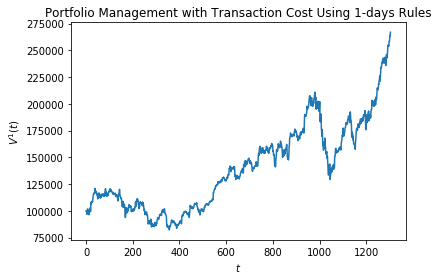

In [201]:
plt.plot(V_1)
plt.title('Portfolio Management with Transaction Cost Using 1-days Rules')
plt.ylabel('$V^1(t)$')
plt.xlabel('$t$')
plt.savefig("7-1")
plt.show()

In [202]:
count/len_testing

0.957088122605364

In [205]:
V_1[-1]

267970.2090094085

5-days rule

In [89]:
# print(rule2)

In [196]:
M_5=[0]*len_testing
N_5=[0]*len_testing
M_5[0]=M_5[1]=M_5[2]=M_5[3]=M_5[4]=100000
V_5=M_5[:4]
gamma0=0.5#中等保守的投资者
e=0.002

count = 0
for i in range(4,len_testing):
    conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    g_pred = -1
    if cut_point_Gaussian[0]>=testing_set_x[i]>=cut_point_Gaussian[1]:
        g_pred = 0
    else:
        g_pred = 1
    
    if max_index == g_pred == 0:
        count += 1
        # 表示接受第二天是U
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]-temp
        N_5[i]=N_5[i]+temp*(1-e)/testing_set[i]
    elif max_index == g_pred == 1:
        count += 1
        # 表示接受第二天是D
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]+temp*(1-e)*testing_set[i]
        N_5[i]=N_5[i]-temp

    if i != len_testing-1:
        M_5[i+1] = M_5[i]
        N_5[i+1] = N_5[i]

    V_5.append(M_5[i]+N_5[i]*testing_set[i])

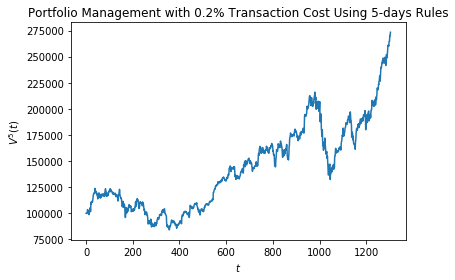

In [197]:
plt.plot(V_5)
plt.title('Portfolio Management with 0.2% Transaction Cost Using 5-days Rules')
plt.ylabel('$V^5(t)$')
plt.xlabel('$t$')
plt.savefig("7-2")
plt.show()

In [198]:
count/len_testing

0.5984674329501916

In [206]:
V_5[-1]

273375.94744355616

"""\\\
Although 1-Day rules' final return is higher than 5-Day rules, I think the 5-Day rules is better than 1-Day rules, for the Apple stock mostly performs Upwards in the last 1/4 time. 1-Day rules' anti-risk ability is much weaker than 5-Day rules.\\\
"""\\\
hahaha, 5-Day rules performs better than 1-Day rules
看长线发展，不能恰烂钱 √

## Extra

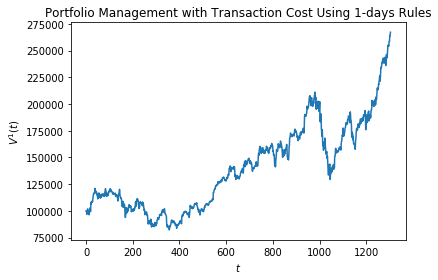

In [212]:
M_1=[0]*len_testing
N_1=[0]*len_testing
M_1[0]=100000
V_1=[]
gamma0=0.5#中等保守的投资者
e=0.001

for i in range(len_testing):
    
    today_conf = list(conf_1d[alphabets(testing_set_d[i])])
    max_index = today_conf.index(max(today_conf))
    if max_index == 0:
        if cut_point_Gaussian[0]>testing_set_x[i]>cut_point_Gaussian[1]:
            count += 1
            # 表示接受第二天是U
            temp = gamma0*M_1[i]
            M_1[i]=M_1[i]-temp
            N_1[i]=N_1[i]+(1-e)*temp/testing_set[i]
    elif max_index == 1:
        if cut_point_Gaussian[0]<testing_set_x[i] or testing_set_x[i]<cut_point_Gaussian[1]:
            count += 1
            # 表示接受第二天是D
            temp = gamma0*N_1[i]
            M_1[i]=M_1[i]+(1-e)*temp*testing_set[i]
            N_1[i]=N_1[i]-temp
    if i < len_testing-1:
        M_1[i+1] = M_1[i]
        N_1[i+1] = N_1[i]
    V_1.append(M_1[i]+N_1[i]*testing_set[i])

plt.plot(V_1)
plt.title('Portfolio Management with Transaction Cost Using 1-days Rules')
plt.ylabel('$V^1(t)$')
plt.xlabel('$t$')
plt.savefig("7-3")
plt.show()

In [213]:
V_1[-1]

267148.7150327706

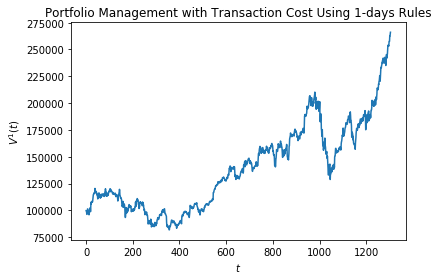

In [214]:
M_1=[0]*len_testing
N_1=[0]*len_testing
M_1[0]=100000
V_1=[]
gamma0=0.5#中等保守的投资者
e=0.005

for i in range(len_testing):
    
    today_conf = list(conf_1d[alphabets(testing_set_d[i])])
    max_index = today_conf.index(max(today_conf))
    if max_index == 0:
        if cut_point_Gaussian[0]>testing_set_x[i]>cut_point_Gaussian[1]:
            count += 1
            # 表示接受第二天是U
            temp = gamma0*M_1[i]
            M_1[i]=M_1[i]-temp
            N_1[i]=N_1[i]+(1-e)*temp/testing_set[i]
    elif max_index == 1:
        if cut_point_Gaussian[0]<testing_set_x[i] or testing_set_x[i]<cut_point_Gaussian[1]:
            count += 1
            # 表示接受第二天是D
            temp = gamma0*N_1[i]
            M_1[i]=M_1[i]+(1-e)*temp*testing_set[i]
            N_1[i]=N_1[i]-temp
    if i < len_testing-1:
        M_1[i+1] = M_1[i]
        N_1[i+1] = N_1[i]
    V_1.append(M_1[i]+N_1[i]*testing_set[i])

plt.plot(V_1)
plt.title('Portfolio Management with Transaction Cost Using 1-days Rules')
plt.ylabel('$V^1(t)$')
plt.xlabel('$t$')
plt.savefig("7-4")
plt.show()

In [215]:
V_1[-1]

266079.05050811486

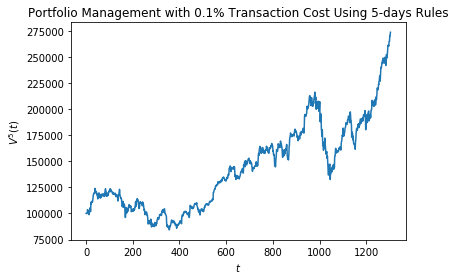

In [216]:
M_5=[0]*len_testing
N_5=[0]*len_testing
M_5[0]=M_5[1]=M_5[2]=M_5[3]=M_5[4]=100000
V_5=M_5[:4]
gamma0=0.5#中等保守的投资者
e=0.001

count = 0
for i in range(4,len_testing):
    conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    g_pred = -1
    if cut_point_Gaussian[0]>=testing_set_x[i]>=cut_point_Gaussian[1]:
        g_pred = 0
    else:
        g_pred = 1
    
    if max_index == g_pred == 0:
        count += 1
        # 表示接受第二天是U
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]-temp
        N_5[i]=N_5[i]+temp*(1-e)/testing_set[i]
    elif max_index == g_pred == 1:
        count += 1
        # 表示接受第二天是D
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]+temp*(1-e)*testing_set[i]
        N_5[i]=N_5[i]-temp

    if i != len_testing-1:
        M_5[i+1] = M_5[i]
        N_5[i+1] = N_5[i]

    V_5.append(M_5[i]+N_5[i]*testing_set[i])

plt.plot(V_5)
plt.title('Portfolio Management with 0.1% Transaction Cost Using 5-days Rules')
plt.ylabel('$V^5(t)$')
plt.xlabel('$t$')
plt.savefig("7-5")
plt.show()

In [217]:
V_5[-1]

273649.87123859004

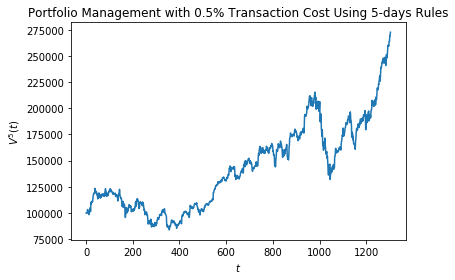

In [218]:
M_5=[0]*len_testing
N_5=[0]*len_testing
M_5[0]=M_5[1]=M_5[2]=M_5[3]=M_5[4]=100000
V_5=M_5[:4]
gamma0=0.5#中等保守的投资者
e=0.005

count = 0
for i in range(4,len_testing):
    conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    g_pred = -1
    if cut_point_Gaussian[0]>=testing_set_x[i]>=cut_point_Gaussian[1]:
        g_pred = 0
    else:
        g_pred = 1
    
    if max_index == g_pred == 0:
        count += 1
        # 表示接受第二天是U
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]-temp
        N_5[i]=N_5[i]+temp*(1-e)/testing_set[i]
    elif max_index == g_pred == 1:
        count += 1
        # 表示接受第二天是D
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]+temp*(1-e)*testing_set[i]
        N_5[i]=N_5[i]-temp

    if i != len_testing-1:
        M_5[i+1] = M_5[i]
        N_5[i+1] = N_5[i]

    V_5.append(M_5[i]+N_5[i]*testing_set[i])

plt.plot(V_5)
plt.title('Portfolio Management with 0.5% Transaction Cost Using 5-days Rules')
plt.ylabel('$V^5(t)$')
plt.xlabel('$t$')
plt.savefig("7-6")
plt.show()

In [219]:
V_5[-1]

272554.17605845525

tax越高，最终受益越少。很合理，因为判别结果相同，交易次数相同，印花税越高交易成本越高，相应扣除本金也就越多。tax=0.1%时，V_5=396336.45677484793; tax=0.2%时，V_5=442219.2201044598; tax=0.5%时，v_5=458661.44275016163.

# 8 Risk-Free Interest

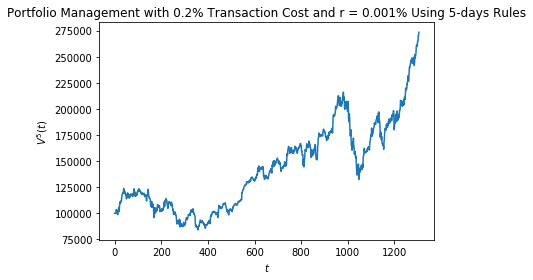

In [261]:
M_5=[0]*len_testing
N_5=[0]*len_testing
r=1e-5
for i in range(5):
    M_5[i] = 100000*(1+r)**i

V_5=M_5[:5]

gamma0=0.5#中等保守的投资者
e=0.002

count = 0
for i in range(4,len_testing):
    conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    g_pred = -1
    if cut_point_Gaussian[0]>=testing_set_x[i]>=cut_point_Gaussian[1]:
        g_pred = 0
    else:
        g_pred = 1
    
    if max_index == g_pred == 0:
        count += 1
        # 表示接受第二天是U
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]-temp
        N_5[i]=N_5[i]+temp*(1-e)/testing_set[i]
    elif max_index == g_pred == 1:
        count += 1
        # 表示接受第二天是D
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]+temp*(1-e)*testing_set[i]
        N_5[i]=N_5[i]-temp

    if i != len_testing-1:
        M_5[i+1] = M_5[i]*(1+r)
        N_5[i+1] = N_5[i]

    V_5.append(M_5[i]+N_5[i]*testing_set[i])

plt.plot(V_5)
plt.title('Portfolio Management with 0.2% Transaction Cost and r = 0.001% Using 5-days Rules')
plt.ylabel('$V^5(t)$')
plt.xlabel('$t$')
plt.savefig("8-1")
plt.show()

In [262]:
V_5[-1]

273392.3247216054

In [263]:
pr = [V_5[i]/(M_5[0]*(1+r)**i) for i in range(len(V_5))]

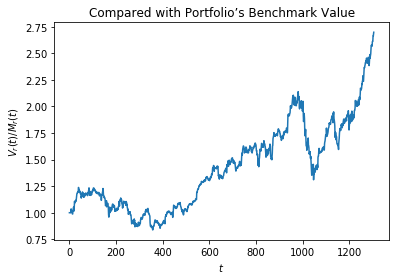

In [264]:
plt.plot(pr)
plt.title('Compared with Portfolio’s Benchmark Value')
plt.ylabel('$V_r(t)/M_r(t)$')
plt.xlabel('$t$')
plt.savefig("8-2")
plt.show()

## Extra

### r = 0.005%

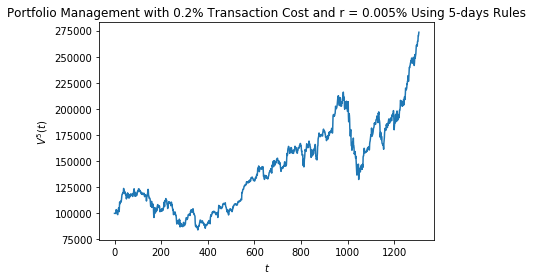

In [265]:
M_5=[0]*len_testing
N_5=[0]*len_testing
r=5e-5
for i in range(5):
    M_5[i] = 100000*(1+r)**i

V_5=M_5[:5]

gamma0=0.5#中等保守的投资者
e=0.002

count = 0
for i in range(4,len_testing):
    conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    g_pred = -1
    if cut_point_Gaussian[0]>=testing_set_x[i]>=cut_point_Gaussian[1]:
        g_pred = 0
    else:
        g_pred = 1
    
    if max_index == g_pred == 0:
        count += 1
        # 表示接受第二天是U
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]-temp
        N_5[i]=N_5[i]+temp*(1-e)/testing_set[i]
    elif max_index == g_pred == 1:
        count += 1
        # 表示接受第二天是D
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]+temp*(1-e)*testing_set[i]
        N_5[i]=N_5[i]-temp

    if i != len_testing-1:
        M_5[i+1] = M_5[i]*(1+r)
        N_5[i+1] = N_5[i]

    V_5.append(M_5[i]+N_5[i]*testing_set[i])

plt.plot(V_5)
plt.title('Portfolio Management with 0.2% Transaction Cost and r = 0.005% Using 5-days Rules')
plt.ylabel('$V^5(t)$')
plt.xlabel('$t$')
plt.savefig("8-3")
plt.show()

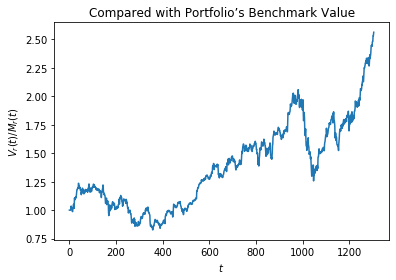

In [266]:
pr = [V_5[i]/(M_5[0]*(1+r)**i) for i in range(len(V_5))]
plt.plot(pr)
plt.title('Compared with Portfolio’s Benchmark Value')
plt.ylabel('$V_r(t)/M_r(t)$')
plt.xlabel('$t$')
plt.savefig("8-4")
plt.show()

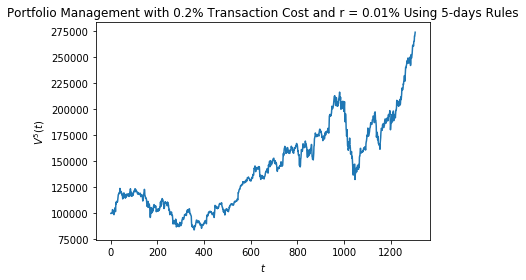

In [267]:
M_5=[0]*len_testing
N_5=[0]*len_testing
r=1e-4
for i in range(5):
    M_5[i] = 100000*(1+r)**i

V_5=M_5[:5]

gamma0=0.5#中等保守的投资者
e=0.002

count = 0
for i in range(4,len_testing):
    conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    g_pred = -1
    if cut_point_Gaussian[0]>=testing_set_x[i]>=cut_point_Gaussian[1]:
        g_pred = 0
    else:
        g_pred = 1
    
    if max_index == g_pred == 0:
        count += 1
        # 表示接受第二天是U
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]-temp
        N_5[i]=N_5[i]+temp*(1-e)/testing_set[i]
    elif max_index == g_pred == 1:
        count += 1
        # 表示接受第二天是D
        temp = gamma0*M_5[i]
        M_5[i]=M_5[i]+temp*(1-e)*testing_set[i]
        N_5[i]=N_5[i]-temp

    if i != len_testing-1:
        M_5[i+1] = M_5[i]*(1+r)
        N_5[i+1] = N_5[i]

    V_5.append(M_5[i]+N_5[i]*testing_set[i])

plt.plot(V_5)
plt.title('Portfolio Management with 0.2% Transaction Cost and r = 0.01% Using 5-days Rules')
plt.ylabel('$V^5(t)$')
plt.xlabel('$t$')
plt.savefig("8-5")
plt.show()

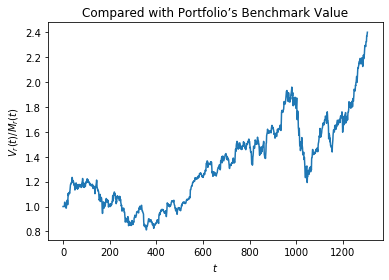

In [268]:
pr = [V_5[i]/(M_5[0]*(1+r)**i) for i in range(len(V_5))]
plt.plot(pr)
plt.title('Compared with Portfolio’s Benchmark Value')
plt.ylabel('$V_r(t)/M_r(t)$')
plt.xlabel('$t$')
plt.savefig("8-6")
plt.show()

日利率变高之后$\rho_r$的值也变小了,我觉得合理。因为test_set的整体趋势上升，股票的份额呈现越来越大的趋势。在其他条件不变的情况下，每日的现金和股票份额相同，$\rho_r$=(现金\*(1-p)+股票\*p)/(现金)，现金变大，p变大，$\rho_r$变小。感受一下……

# 9 Greed

In [285]:
gamma=[0.1, 0.3, 0.5, 0.7, 0.9]
V=[[],[],[],[],[]]
for g in range(len(gamma)):
    M_5=[0]*len_testing
    N_5=[0]*len_testing
    r=1e-5
    for i in range(5):
        M_5[i] = 100000*(1+r)**i

    V[g]=M_5[:5]

    gamma0=gamma[g]
    e=0.002

    count = 0
    for i in range(4,len_testing):
        conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
        max_index = conf_list.index(max(conf_list))

        g_pred = -1
        if cut_point_Gaussian[0]>=testing_set_x[i]>=cut_point_Gaussian[1]:
            g_pred = 0
        else:
            g_pred = 1
        
        if max_index == g_pred == 0:
            count += 1
            # 表示接受第二天是U
            temp = gamma0*M_5[i]
            M_5[i]=M_5[i]-temp
            N_5[i]=N_5[i]+temp*(1-e)/testing_set[i]
        elif max_index == g_pred == 1:
            count += 1
            # 表示接受第二天是D
            temp = gamma0*M_5[i]
            M_5[i]=M_5[i]+temp*(1-e)*testing_set[i]
            N_5[i]=N_5[i]-temp

        if i != len_testing-1:
            M_5[i+1] = M_5[i]*(1+r)
            N_5[i+1] = N_5[i]

        V[g].append(M_5[i]+N_5[i]*testing_set[i])

258249.18741851414


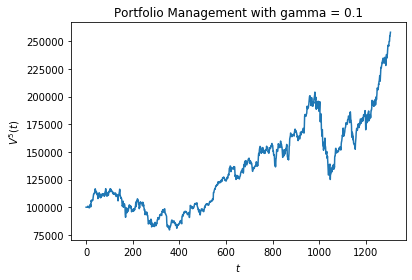

271381.4393544028


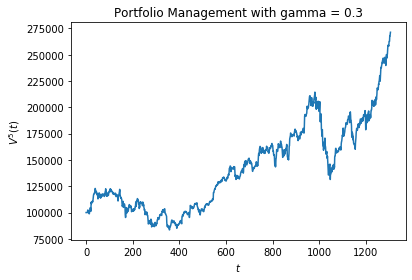

273392.3247216054


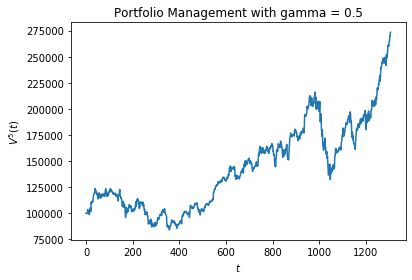

274384.47660196474


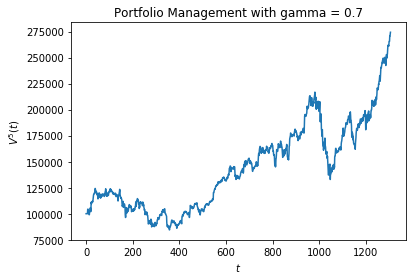

275377.36863414


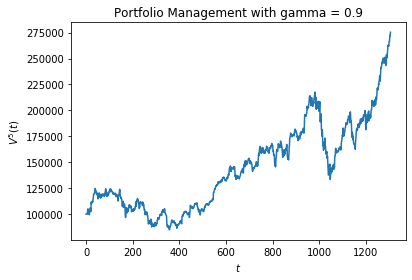

In [286]:
for g in range(len(gamma)):
    print(V[g][-1])
    plt.plot(V[g])
    plt.title('Portfolio Management with gamma = {}'.format(gamma[g]))
    plt.ylabel('$V^5(t)$')
    plt.xlabel('$t$')
    plt.savefig("9-{}".format(g))
    plt.show()

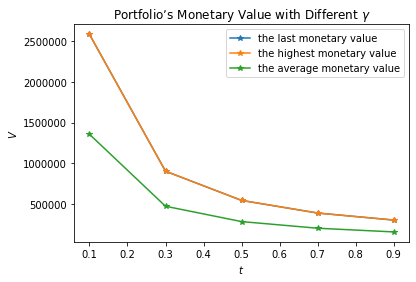

In [277]:
line1=[]
line2=[]
line3=[]
for i in range(len(gamma)):
    line1.append(V[i][-1]/gamma[i])
    line2.append(np.max(V[i])/gamma[i])
    line3.append(np.mean(V[i])/gamma[i])
#写report的话把time加上或许好看一点
plt.plot(gamma,line1,'*-',label="the last monetary value")
plt.plot(gamma,line2,'*-',label="the highest monetary value")
plt.plot(gamma,line3,'*-',label="the average monetary value")

plt.title('Portfolio’s Monetary Value with Different $\gamma$')
plt.ylabel('$V$')
plt.xlabel('$t$')
plt.savefig("9-6")

plt.legend()
plt.show()

## Extra

In [294]:
gamma=np.linspace(0.05,1,20)
V=[]

for i in range(20):
    V.append([])

for g in range(len(gamma)):
    M_5=[0]*len_testing
    N_5=[0]*len_testing
    r=1e-5
    for i in range(5):
        M_5[i] = 100000*(1+r)**i

    V[g]=M_5[:5]

    gamma0=gamma[g]
    e=0.002

    count = 0
    for i in range(4,len_testing):
        conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
        max_index = conf_list.index(max(conf_list))

        g_pred = -1
        if cut_point_Gaussian[0]>=testing_set_x[i]>=cut_point_Gaussian[1]:
            g_pred = 0
        else:
            g_pred = 1
        
        if max_index == g_pred == 0:
            count += 1
            # 表示接受第二天是U
            temp = gamma0*M_5[i]
            M_5[i]=M_5[i]-temp
            N_5[i]=N_5[i]+temp*(1-e)/testing_set[i]
        elif max_index == g_pred == 1:
            count += 1
            # 表示接受第二天是D
            temp = gamma0*M_5[i]
            M_5[i]=M_5[i]+temp*(1-e)*testing_set[i]
            N_5[i]=N_5[i]-temp

        if i != len_testing-1:
            M_5[i+1] = M_5[i]*(1+r)
            N_5[i+1] = N_5[i]*(1+r)

        V[g].append(M_5[i]+N_5[i]*testing_set[i])

In [290]:
for i in range(20):
    print(V[i][:20])

[100000.0, 100001.0, 100002.00001000002, 100003.00003000011, 100004.00006000043, 99993.99965999443, 100055.47344986799, 100433.05297182842, 100444.97274389483, 100194.91952772699, 100275.13058173319, 100220.76566054013, 99828.91712056972, 99711.92137540091, 99704.77237319302, 100272.84870679666, 100470.74442134009, 101268.52237443643, 101424.70246566352, 101456.33222330545]
[100000.0, 100001.0, 100002.00001000002, 100003.00003000011, 100004.00006000043, 99983.99925998843, 100106.94684973595, 100841.93198864751, 100864.21552127998, 100375.89166396997, 100532.6712369321, 100428.40454206086, 99682.47129890292, 99460.8446466847, 99448.71554916882, 100478.29266157257, 100829.97678885149, 102209.64213132202, 102481.66827076461, 102537.20298262005]
[100000.0, 100001.0, 100002.00001000002, 100003.00003000011, 100004.00006000043, 99973.99885998243, 100159.42029960491, 101232.63720045928, 101264.72854215898, 100550.91668873458, 100781.47231210467, 100632.48183058214, 99569.20388692128, 99255.342

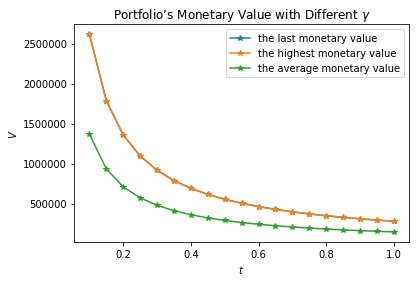

In [293]:
lines=[[],[],[]]
for i in range(1,len(gamma)):
    lines[0].append(V[i][-1]/gamma[i])
    lines[1].append(np.max(V[i])/gamma[i])
    lines[2].append(np.mean(V[i])/gamma[i])
# print(lines[0])
# print(lines[0])
# print(lines[0])
#写report的话把time加上或许好看一点
plt.plot(gamma[1:20],lines[0],'*-',label="the last monetary value")
plt.plot(gamma[1:20],lines[1],'*-',label="the highest monetary value")
plt.plot(gamma[1:20],lines[2],'*-',label="the average monetary value")
plt.title('Portfolio’s Monetary Value with Different $\gamma$')
plt.ylabel('$V$')
plt.xlabel('$t$')
plt.savefig("9-2")
plt.legend()
plt.show()

[0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65 0.7
 0.75 0.8  0.85 0.9  0.95 1.  ]
[-1311802747922.959, 2615824.0686233127, 1786391.3779904752, 1357611.2965803233, 1094540.2115433943, 916399.3933296247, 787801.1034973408, 690675.9389881751, 614796.2123041326, 553928.1914805715, 504053.24590909947, 462463.4943860757, 427267.4533651715, 397103.82835126243, 370967.8648287349, 348101.79580799, 327923.3968299808, 309978.03878496983, 293905.6903238707, 279417.69558842655]
[-1311802747922.959, 2615824.0686233127, 1786391.3779904752, 1357611.2965803233, 1094540.2115433943, 916399.3933296247, 787801.1034973408, 690675.9389881751, 614796.2123041326, 553928.1914805715, 504053.24590909947, 462463.4943860757, 427267.4533651715, 397103.82835126243, 370967.8648287349, 348101.79580799, 327923.3968299808, 309978.03878496983, 293905.6903238707, 279417.69558842655]
[-1311802747922.959, 2615824.0686233127, 1786391.3779904752, 1357611.2965803233, 1094540.2115433943, 916399.3933296247, 78

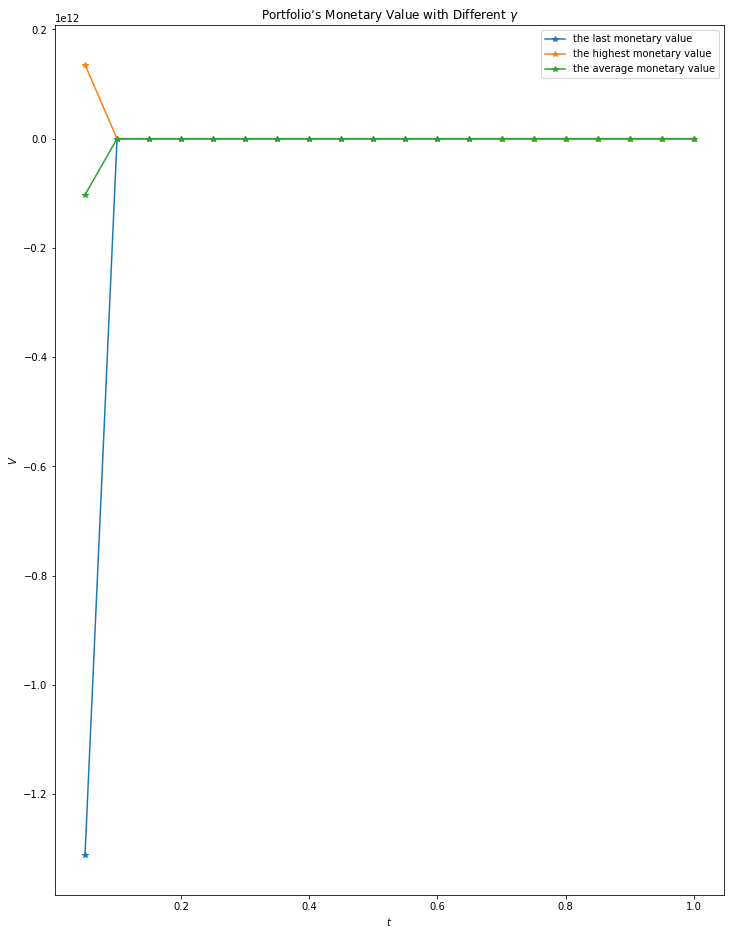

In [298]:
lines=[[],[],[]]
for i in range(len(gamma)):
    lines[0].append(V[i][-1]/gamma[i])
    lines[1].append(np.max(V[i])/gamma[i])
    lines[2].append(np.mean(V[i])/gamma[i])
print(gamma)
print(lines[0])
print(lines[0])
print(lines[0])
#写report的话把time加上或许好看一点
plt.figure(figsize=(12,16))
plt.plot(gamma,lines[0],'*-',label="the last monetary value")
plt.plot(gamma,lines[1],'*-',label="the highest monetary value")
plt.plot(gamma,lines[2],'*-',label="the average monetary value")
plt.title('Portfolio’s Monetary Value with Different $\gamma$')
plt.ylabel('$V$')
plt.xlabel('$t$')
# plt.savefig("9-2")
plt.legend()
plt.show()

越贪心其实离期望收益越远吼？(但就Apple的股票来看，确实越贪心收益越大……对吗？review的时候可以看看这里)

# 10 Alternative Portfolio Measure

In [269]:
# gamma=[0.1, 0.3, 0.5, 0.7, 0.9]
# V=[[],[],[],[],[]]
# W=[[],[],[],[],[]]
# for g in range(len(gamma)):
#     M_5=[0]*5217
#     N_5=[0]*5217
#     M_5[0]=M_5[1]=M_5[2]=M_5[3]=M_5[4]=M_5[5]=100000
#     r=1e-5
#     gamma0=gamma[g]
#     e=0.002
#     for i in range(4,len_testing):
#         M_5[i]=(1+r)*M_5[i]
#         if count_U[alphabets(testing_set_d[i-5])][alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])]>count_D[alphabets(testing_set_d[i-5])][alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])] and cut_point_FD[0]>=testing_set_x[i]>=cut_point_FD[1]:
#             #表示接受
#     #         print("U")
#             M_5[i+1]=M_5[i]-gamma0*M_5[i]
#             N_5[i+1]=N_5[i]+(1-e)*gamma0*M_5[i]/apple_price[len_learning+i]
#         elif count_U[alphabets(testing_set_d[i-5])][alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])]<count_D[alphabets(testing_set_d[i-5])][alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])] and (cut_point_FD[0]<testing_set_x[i] or testing_set_x[i]<cut_point_FD[1]):
#     #         print("D")
#             M_5[i+1]=M_5[i]+(1-e)*gamma0*N_5[i]*apple_price[len_learning+i]
#             N_5[i+1]=N_5[i]-gamma0*N_5[i]
#         else:
#     #         print("H")
#             M_5[i+1]=M_5[i]
#             N_5[i+1]=N_5[i]
    
#         V[g].append(M_5[i+1]+N_5[i+1]*apple_price[len_learning+i])
#         W[g].append(M_5[i+1]/testing_set[i]+N_5[i+1])

In [270]:
# W

In [271]:
# V

In [272]:
# for i in range(len(gamma)):
#     for j in range(1,len(V[i])):
#         V[i][j]=np.log(V[i][j]/V[i][0])
#         W[i][j]=np.log(W[i][j]/W[i][0])
#     V[i][0]=0
#     W[i][0]=0
# #写report的话把time加上或许好看一点
#     plt.plot(V[i],label="$v(t)$")
#     plt.plot(W[i],label="$w(t)$")
#     plt.legend()
#     #这些图片要存
#     plt.show()

In [285]:
gamma=[0.1, 0.3, 0.5, 0.7, 0.9]
V=[[],[],[],[],[]]
W=[[],[],[],[],[]]
for g in range(len(gamma)):
    M_5=[0]*5217
    N_5=[0]*5217
    r=1e-5
    gamma0=gamma[g]
    for i in range(5):
        M_5[i] = 100000*(1+r)**i
        
    V[g]=M_5[:5]
    W[g]=M_5[:5]
    
    for i in range(5):
        W[g][i] = W[g][i]/testing_set[i]
        
    e=0.002

    for i in range(4,len_testing):
    
        M_5[i]=(1+r)*M_5[i]

        conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
        max_index = conf_list.index(max(conf_list))

        bayes_pred = -1
        if cut_point_FD[0]>=testing_set_x[i]>=cut_point_FD[1]:
            bayes_pred = 0
        else:
            bayes_pred = 1

        if max_index == bayes_pred == 0:
            # 表示接受第二天是U
            M_5[i+1]=M_5[i]-gamma0*M_5[i]
            N_5[i+1]=N_5[i]+gamma0*(1-e)*M_5[i]/testing_set[i]
        elif max_index == bayes_pred == 1:
            # 表示接受第二天是D
            M_5[i+1]=M_5[i]+gamma0*(1-e)*N_5[i]*testing_set[i]
            N_5[i+1]=N_5[i]-gamma0*N_5[i]
        else:
            M_5[i+1] = M_5[i]
            N_5[i+1] = N_5[i]

        V[g].append(M_5[i+1]+N_5[i+1]*testing_set[i])
        W[g].append(M_5[i+1]/testing_set[i]+N_5[i+1])

In [286]:
# W

In [287]:
# V

In [288]:
# plt.plot(V[0],label="$v(t)$")
# plt.plot(W[0],label="$w(t)$")
# plt.plot(N_5,)
# plt.legend()
# #这些图片要存
# plt.show()

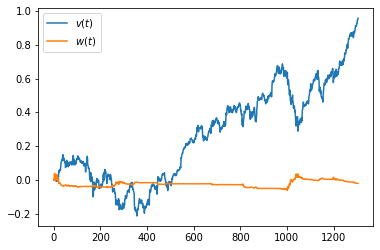

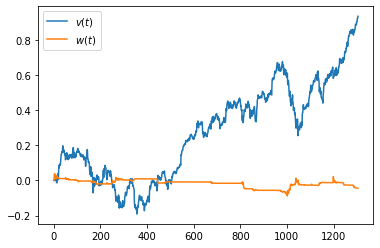

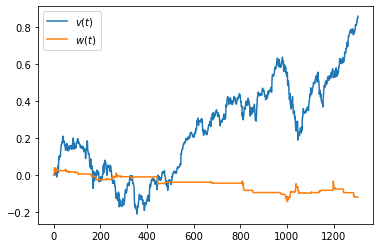

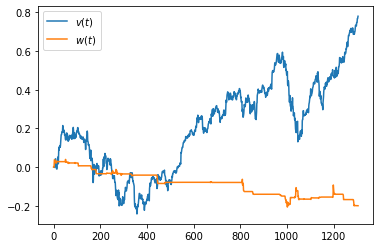

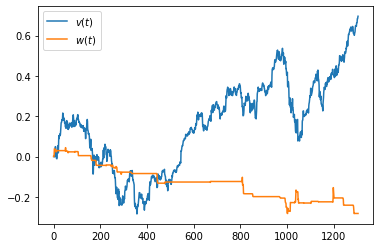

In [289]:
Vt_0 = V.copy()
Wt_0 = W.copy()
for i in range(len(gamma)):
    for j in range(1,len(V[i])):
        Vt_0[i][j]=np.log(V[i][j]/V[i][0])
        Wt_0[i][j]=np.log(W[i][j]/W[i][0])
        
    Vt_0[i][0]=0
    Wt_0[i][0]=0
#写report的话把time加上或许好看一点
    plt.plot(Vt_0[i],label="$v(t)$")
    plt.plot(Wt_0[i],label="$w(t)$")
    plt.legend()
    #这些图片要存
    plt.show()

一样 $\gamma$ 变大， $v(t)$ $w(t)$也变大

In [ ]:
# gamma=[0.1, 0.3, 0.5, 0.7, 0.9]
# V=[[],[],[],[],[]]
# W=[[],[],[],[],[]]
# for g in range(len(gamma)):
#     M_5=[0]*5217
#     N_5=[0]*5217
#     M_5[0]=M_5[1]=M_5[2]=M_5[3]=M_5[4]=M_5[5]=100000
#     r=1e-5
#     gamma0=gamma[g]
#     e=0.002
#     for i in range(4,len_testing):
#         M_5[i]=(1+r)*M_5[i]
#         if count_U[alphabets(testing_d[i-5])][alphabets(testing_d[i-4])][alphabets(testing_d[i-3])][alphabets(testing_d[i-2])][alphabets(testing_d[i-1])]>count_D[alphabets(testing_d[i-5])][alphabets(testing_d[i-4])][alphabets(testing_d[i-3])][alphabets(testing_d[i-2])][alphabets(testing_d[i-1])] and cut_point_FD[0]>=testing_set_x[i]>=cut_point_FD[1]:
#             #表示接受
#     #         print("U")
#             M_5[i+1]=M_5[i]-gamma0*M_5[i]
#             N_5[i+1]=N_5[i]+(1-e)*gamma0*M_5[i]/apple_price[len_learning+i]
#         elif count_U[alphabets(testing_d[i-5])][alphabets(testing_d[i-4])][alphabets(testing_d[i-3])][alphabets(testing_d[i-2])][alphabets(testing_d[i-1])]<count_D[alphabets(testing_d[i-5])][alphabets(testing_d[i-4])][alphabets(testing_d[i-3])][alphabets(testing_d[i-2])][alphabets(testing_d[i-1])] and (cut_point_FD[0]<testing_set_x[i] or testing_set_x[i]<cut_point_FD[1]):
#     #         print("D")
#             M_5[i+1]=M_5[i]+(1-e)*gamma0*N_5[i]*apple_price[len_learning+i]
#             N_5[i+1]=N_5[i]-gamma0*N_5[i]
#         else:
#     #         print("H")
#             M_5[i+1]=M_5[i]
#             N_5[i+1]=N_5[i]
    
#         V[g].append(M_5[i+1]+N_5[i+1]*apple_price[len_learning+i])
#         W[g].append(M_5[i+1]/apple_price[len_learning+i]+N_5[i+1])


/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


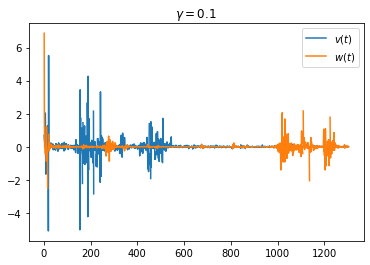

/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


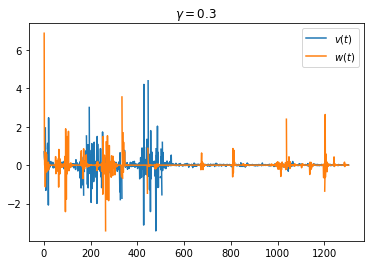

/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


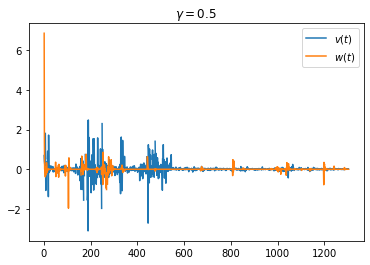

/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


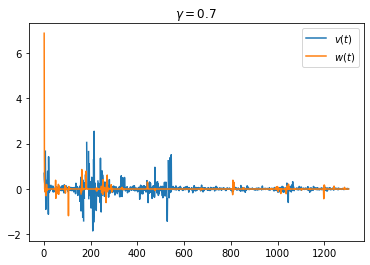

/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log
  """
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: invalid value encountered in log
  
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in double_scalars
  """
/Users/zhangziyang/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in double_scalars
  


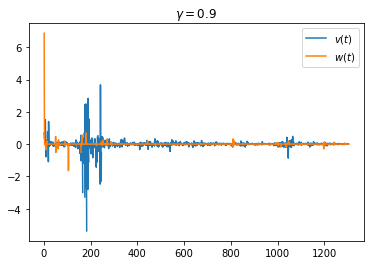

In [290]:
Vtt1 = V.copy()
Wtt1 = W.copy()
for i in range(len(gamma)):
    for j in range(len(V[i])-1,0,-1):
        Vtt1[i][j]=np.log(V[i][j]/V[i][j-1])
        Wtt1[i][j]=np.log(W[i][j]/W[i][j-1])
    del Vtt1[i][0]
    del Wtt1[i][0]
# print(V[0])
    #写report的话把time加上或许好看一点
    plt.plot(Vtt1[i],label="$v(t)$")
    plt.plot(Wtt1[i],label="$w(t)$")
    plt.title("$\gamma=${}".format(str(gamma[i])))
    plt.legend()
    #这些图片要存
    plt.show()

Extra

Efficient Frontier

In [294]:
M_5=[0]*5217
N_5=[0]*5217
r=1e-5

gamma0=0.5

e=0.002

for i in range(4):
    M_5[i] = 100000*(1+r)**i

V_5=M_5[:4]

for i in range(4,len_testing):

    M_5[i]=(1+r)*M_5[i-1]

    conf_list = [conf_U[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_D[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])], conf_H[alphabets(testing_set_d[i-4])][alphabets(testing_set_d[i-3])][alphabets(testing_set_d[i-2])][alphabets(testing_set_d[i-1])][alphabets(testing_set_d[i])]]
    max_index = conf_list.index(max(conf_list))

    bayes_pred = -1
    if cut_point_FD[0]>=testing_set_x[i]>=cut_point_FD[1]:
        bayes_pred = 0
    else:
        bayes_pred = 1

    if max_index == bayes_pred == 0:
        # 表示接受第二天是U
        M_5[i+1]=M_5[i]-gamma0*M_5[i]
        N_5[i+1]=N_5[i]+gamma0*(1-e)*M_5[i]/testing_set[i]
    elif max_index == bayes_pred == 1:
        # 表示接受第二天是D
        M_5[i+1]=M_5[i]+gamma0*(1-e)*N_5[i]*testing_set[i]
        N_5[i+1]=N_5[i]-gamma0*N_5[i]
    else:
        M_5[i+1] = M_5[i]
        N_5[i+1] = N_5[i]

    V_5.append(M_5[i+1]+N_5[i+1]*testing_set[i])

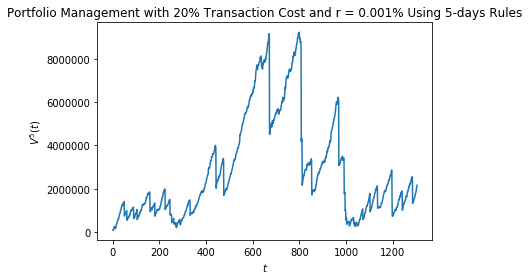

In [295]:
plt.plot(V_5)
plt.title('Portfolio Management with 20% Transaction Cost and r = 0.001% Using 5-days Rules')
plt.ylabel('$V^5(t)$')
plt.xlabel('$t$')
plt.savefig("11-1")
plt.show()